#### 30 Oct 2024
#### Temas por revisar en este Notebook:

*   * Acuerdo con profesora guía:
*   * Definir un período relevante para Chile
*   * Usar df con % ponderado para todos los países
*   * Construir la red de similaridad (tendrá 1 nodo por país)
*   * Analizar la red, y clusters y métricas

---


### Código

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain
from IPython.display import Markdown, display
import glob
from PIL import Image

#### Cargar el dataset de Manifesto Project al dataframe 'df'

In [2]:
file_path = "data/MPDataset_MPDS2024a.csv"
df = pd.read_csv(file_path, na_values=['', 'NaN', 'N/A', None]).fillna(0)

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8846/977512804.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values=['', 'NaN', 'N/A', None]).fillna(0)


In [3]:
df.head()

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,11220,Communist Party of Sweden,SKP,20,...,0.0,0.0,0.0,9.60,1.9,1.900,0.0,1.900,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,11320,Social Democratic Labour Party,SAP,30,...,0.0,0.0,0.0,-37.80,3.3,2.200,33.4,5.600,2024a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,11420,People’s Party,FP,40,...,0.0,0.0,0.0,9.50,3.2,6.400,14.3,1.600,2024a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,11620,Right Party,0,60,...,0.0,0.0,0.0,28.00,1.8,22.800,10.6,0.000,2024a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,11810,Agrarian Party,0,80,...,0.0,0.0,0.0,23.81,0.0,19.048,0.0,4.762,2024a,U4SCRD


#### Crear campo 'agno' para registrar el año del programa de gobierno

In [4]:
# Insert column 'agno' into the dataframe, of type int, to the right of column 'date'
df.insert(df.columns.get_loc('date') + 1, 'agno', df['edate'].str[-4:].astype(int))

# List unique values of new column 'agno'
unique_agno_values = df['agno'].unique()
# print(unique_agno_values)

In [5]:
df.head()

,country,countryname,oecdmember,eumember,edate,date,agno,party,partyname,partyabbrev,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,1944,11220,Communist Party of Sweden,SKP,...,0.0,0.0,0.0,9.60,1.9,1.900,0.0,1.900,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,1944,11320,Social Democratic Labour Party,SAP,...,0.0,0.0,0.0,-37.80,3.3,2.200,33.4,5.600,2024a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,1944,11420,People’s Party,FP,...,0.0,0.0,0.0,9.50,3.2,6.400,14.3,1.600,2024a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,1944,11620,Right Party,0,...,0.0,0.0,0.0,28.00,1.8,22.800,10.6,0.000,2024a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,1944,11810,Agrarian Party,0,...,0.0,0.0,0.0,23.81,0.0,19.048,0.0,4.762,2024a,U4SCRD


In [6]:
unique_country_count = df['countryname'].nunique()
print(f"Number of unique countries: {unique_country_count}")

Number of unique countries: 67


In [7]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


#### Agrupamos los países a 1 registro por año, sumando las variables 'perxxx'

##### Agregamos la columna 'ventana_5' para agrupar las elecciones en períodos de 5 años entre 1920 y 2023
* Período 5 años : 1920, 1925, 1930, ... 2000, 2005, 2010, 2015, 2020, 2025

In [8]:
# cargar períodos
df_ventana_10 = pd.read_excel('data/Ventana_10.xlsx')
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')

In [161]:
df_ventana_5

,agno,ventana
0,1920,1
1,1921,1
2,1922,1
3,1923,1
4,1924,1
...,...,...
99,2019,20
100,2020,21
101,2021,21
102,2022,21


In [9]:
# en 'df' Insertamos columnas 'ventana_10' y 'ventana_5'
df = df.merge(df_ventana_10, on='agno', how='left').rename(columns={'ventana': 'ventana_10'})
df = df.merge(df_ventana_5, on='agno', how='left').rename(columns={'ventana': 'ventana_5'})

# Get the position of the 'agno' column
agno_index = df.columns.get_loc('agno')

# Move 'ventana_10' and 'ventana_5' to the right of 'agno'
columns = list(df.columns)
columns.insert(agno_index + 1, columns.pop(columns.index('ventana_10')))
columns.insert(agno_index + 2, columns.pop(columns.index('ventana_5')))
df = df[columns]

In [10]:
df

,country,countryname,oecdmember,eumember,edate,date,agno,ventana_10,ventana_5,party,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11220,...,0.0,0.000,0.0,9.600,1.900,1.900,0.000,1.900,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11320,...,0.0,0.000,0.0,-37.800,3.300,2.200,33.400,5.600,2024a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11420,...,0.0,0.000,0.0,9.500,3.200,6.400,14.300,1.600,2024a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11620,...,0.0,0.000,0.0,28.000,1.800,22.800,10.600,0.000,2024a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11810,...,0.0,0.000,0.0,23.810,0.000,19.048,0.000,4.762,2024a,U4SCRD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181510,...,0.0,5.000,0.0,12.500,0.833,7.500,14.167,0.000,2024a,HSQT6Y
5147,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181520,...,0.0,1.042,0.0,-6.771,3.385,1.042,22.135,1.562,2024a,B6QCSE
5148,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181710,...,0.0,3.497,0.0,19.580,0.699,10.664,11.364,0.000,2024a,OS725O
5149,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181910,...,0.0,3.289,0.0,-6.579,0.658,0.658,28.947,0.000,2024a,XKM7J7


#### Hagamos la ponderación por año por país
#### Debemos elegir entre 'pervote' o 'presvote' para ponderar. Si existe 'presvote' usamos ese si no, 'pervote'

In [11]:
# Identificar las columnas que contienen los porcentajes
lista_columnas = [col for col in df.columns if col.startswith('per') and (col[4].isdigit() or col[6] == '_')]

# Función para calcular el promedio ponderado con base en presvote o pervote
def calcular_promedio_ponderado(grupo):
    # Si presvote contiene solo ceros o valores nulos, se usará pervote
    if (grupo['presvote'].fillna(0) == 0).all():
        peso = grupo['pervote']
        tipovoto = 'pervote'
    else:
        peso = grupo['presvote']
        tipovoto = 'presvote'

    # Si ambas están en cero o vacías
    if peso.isna().all() or (peso == 0).all():
        tipovoto = 'no hay pervote ni presvote'
        peso = pd.Series(np.ones(len(grupo)))  # usar peso 1 para calcular el promedio simple

    # Calcular el promedio ponderado para cada columna de 'lista_columnas'
    ponderado = {}
    for col in lista_columnas:
        ponderado[col] = np.average(grupo[col], weights=peso)

    # Devolver un nuevo registro con los datos
    return pd.Series(
        [grupo['agno'].iloc[0], grupo['countryname'].iloc[0], grupo['ventana_10'].iloc[0], 
         grupo['ventana_5'].iloc[0], tipovoto] + list(ponderado.values()),
        index=['agno', 'countryname', 'ventana_10', 'ventana_5', 'tipovoto'] + lista_columnas
    )

# Agrupar por countryname y agno, y aplicar la función de promedio ponderado
df_ponderado = df.groupby(['countryname', 'agno']).apply(calcular_promedio_ponderado).reset_index(drop=True)


In [12]:
df_ponderado

,agno,countryname,ventana_10,ventana_5,tipovoto,per101,per102,per103,per104,per105,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,1991,Albania,190,15,pervote,2.140848,0.000000,1.559835,0.581013,0.193536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,1992,Albania,190,15,pervote,0.972966,0.000000,0.000000,1.465758,0.137749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,1996,Albania,190,16,pervote,1.945808,0.000000,0.020491,0.472585,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,1997,Albania,190,16,pervote,1.770988,0.000000,0.031388,3.046506,0.015910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,2001,Albania,200,17,pervote,2.392570,0.000000,0.000000,2.757403,0.026619,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,2008,United States,200,18,pervote,1.978711,0.088485,0.044020,5.839310,0.088485,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
842,2012,United States,210,19,presvote,0.505120,0.161887,0.189797,7.527242,1.491961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
843,2016,United States,210,20,presvote,0.866280,0.111349,0.000000,5.807609,0.763045,...,0.803674,0.088884,0.160093,0.263441,1.787391,0.022465,0.078721,0.0,1.657539,0.022465
844,2020,United States,220,21,presvote,1.190682,0.129249,0.161450,5.565559,1.951804,...,0.449422,0.086907,0.547069,0.082574,1.909957,0.021965,0.043453,0.0,1.991430,0.021965


#### Ordenemos el dataset según períodos de 5 años. Para  cada país, se sumarán los valores de las variables de aquellos años dengtro del período


In [13]:
# Cambiemos el nombre a 'df_f
df_f = df_ponderado.copy()


#### df_5: Consolidamos por país y por 'ventana_5'

In [14]:
# Crear el dataframe 'df_5' sumando los valores de las columnas que comienzan con 'per' agrupados por 'countryname' y 'ventana_5'
df_5 = df_f.groupby(['countryname', 'ventana_5'])[lista_columnas].sum().reset_index()

# Mostrar las primeras filas del nuevo dataframe 'df_5'
df_5


,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.000000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Albania,16,3.716797,0.000000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Albania,17,2.392570,0.000000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Argentina,14,0.000000,0.000000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.000000,0.326532,0.000000,0.000000,0.000000,0.000000,0.0,2.495280,0.000000
4,Argentina,16,0.254185,0.020140,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.000000,0.443809,0.000000,0.809128,0.000000,0.000000,0.0,2.573783,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,United States,18,1.978711,0.088485,0.044020,5.839310,0.088485,1.308294,8.863648,0.343947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
600,United States,19,0.505120,0.161887,0.189797,7.527242,1.491961,0.658037,6.073936,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
601,United States,20,0.866280,0.111349,0.000000,5.807609,0.763045,0.635581,4.669601,0.000000,...,0.803674,0.088884,0.160093,0.263441,1.787391,0.022465,0.078721,0.0,1.657539,0.022465
602,United States,21,1.190682,0.129249,0.161450,5.565559,1.951804,0.480557,3.907785,0.020377,...,0.449422,0.086907,0.547069,0.082574,1.909957,0.021965,0.043453,0.0,1.991430,0.021965


In [15]:
df_5.shape

(604, 144)

In [16]:
all_per_variables = [col for col in df_5.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


#### df_5_extended: Agreguemos registros cero para todos los países para los períodos en que no hay información. Esto da consistencia en la comparación, se refleja que para ciertos períodos no hay datos lo que evita sesgo en la comparación, y mantiene la uniformidad en la red de similaridad

In [17]:
# Paso 1: Obtener la lista de todos los países en el dataframe
all_countries = df_5['countryname'].unique()

# Paso 2: Crear un DataFrame con todos los períodos posibles (1 al 21)
all_periods = pd.DataFrame({'ventana_5': list(range(1, 22))})

# Paso 3: Crear un DataFrame vacío para almacenar los registros faltantes
missing_periods_all = pd.DataFrame()

# Paso 4: Iterar sobre todos los países y generar registros con ceros para los períodos faltantes
for country in all_countries:
    # Filtrar los períodos existentes del país en df_5
    existing_periods = df_5[df_5['countryname'] == country]['ventana_5'].unique()
    
    # Determinar los períodos faltantes para el país
    missing_periods = all_periods[~all_periods['ventana_5'].isin(existing_periods)]
    
    # Crear registros con valores cero para los períodos faltantes
    missing_data = pd.DataFrame({
        'countryname': [country] * len(missing_periods),
        'ventana_5': missing_periods['ventana_5']
    })
    
    # Asignar valores cero a todas las variables 'per'
    for col in all_per_variables:
        missing_data[col] = 0.0
    
    # Agregar los registros faltantes al DataFrame total
    missing_periods_all = pd.concat([missing_periods_all, missing_data], ignore_index=True)

# Paso 5: Combinar los registros faltantes con el DataFrame original
df_5_extended = pd.concat([df_5, missing_periods_all], ignore_index=True)

# Paso 6: Verificar que ahora todos los países tengan datos para todos los períodos
df_5_extended.groupby('countryname')['ventana_5'].nunique()


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8846/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_data[col] = 0.0
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8846/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_data[col] = 0.0
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8846/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

countryname
Albania           21
Argentina         21
Armenia           21
Australia         21
Austria           21
                  ..
Turkey            21
Ukraine           21
United Kingdom    21
United States     21
Uruguay           21
Name: ventana_5, Length: 67, dtype: int64

In [18]:
df_5_extended.head()

,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.00000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Albania,16,3.716797,0.00000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Albania,17,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Argentina,14,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.0,0.326532,0.0,0.000000,0.0,0.0,0.0,2.495280,0.0
4,Argentina,16,0.254185,0.02014,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.0,0.443809,0.0,0.809128,0.0,0.0,0.0,2.573783,0.0


### Correlación de Pearson y Threshold

#### Correlación de Pearson

**Qué es**: La correlación de Pearson mide la relación lineal entre dos conjuntos de datos. En este caso, mediría cómo se correlacionan los porcentajes de las etiquetas temáticas entre dos programas de gobierno.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), calcula la correlación de Pearson usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es `[x1,x2,...,x56]` y el de "Alemania_1980" es `[y1,y2,...,y56]`, entonces la correlación de Pearson se calcula como:

$$
r = \frac{\sum_{i=1}^{56} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{56} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{56} (y_i - \bar{y})^2}}
$$

Donde $\bar{x}$ y $\bar{y}$ son las medias de los vectores de porcentajes.

#### Interpretación de la Correlación:
El valor de $r$ está en el rango $[-1,1]$, donde:

- $r = 1$ indica una correlación positiva perfecta (discursos muy similares en la distribución temática).
- $r = -1$ indica una correlación negativa perfecta (discursos temáticamente opuestos).
- $r \approx 0$ indica que no hay una correlación lineal significativa.

#### Uso en la Red de Similaridad:
Usaremos el valor absoluto de la correlación ($|r|$) para ponderar la arista entre dos programas. Valores cercanos a 1 indican una fuerte similaridad temática, mientras que valores cercanos a 0 indican poca o ninguna similaridad.

---


### CREEMOS LA RED

#### Los nodos son pares país-período, y los enlaces son la correlación entre ambos. Todos con Todos. Feature vector completo

#### PASO 1: CÁLCULO DE CORRELACIÓN Todos con Todos

In [67]:
# CORRELATION MATRIX

from scipy.stats import spearmanr
from tqdm import tqdm  # Librería para visualizar el progreso

# Crear un identificador único para cada par de 'countryname' y 'ventana_5'
df_5_extended['pair'] = df_5_extended['countryname'] + '_' + df_5_extended['ventana_5'].astype(str)

# Filtrar solo las columnas 'per' y la columna 'pair'
columns_per = [col for col in df_5_extended.columns if col.startswith('per')]
df_corr = df_5_extended.set_index('pair')[columns_per]

# Crear un dataframe para almacenar las correlaciones
correlation_matrix = pd.DataFrame(index=df_corr.index, columns=df_corr.index)

# Calcular el número total de combinaciones de pares
total_combinations = len(df_corr) * (len(df_corr) - 1) / 2

# Calcular la correlación de Spearman para cada par con cada par utilizando una única barra de progreso
try:
    with tqdm(total=total_combinations, desc="Calculando correlaciones de Spearman") as pbar:
        for i, pair1 in enumerate(df_corr.index):
            country1 = pair1.split('_')[0]  # Extraer el nombre del país del par1
            for j, pair2 in enumerate(df_corr.index[i+1:], start=i+1):  # Evitar repeticiones y calcular solo una vez por par
                country2 = pair2.split('_')[0]  # Extraer el nombre del país del par2

                # Verificar si ambos pares pertenecen al mismo país
                if country1 == country2:
                    corr = 0  # Asignar correlación 0 para pares del mismo país
                else:
                    # Verificar si ambas filas tienen solo ceros
                    if (df_corr.loc[pair1].sum() == 0) and (df_corr.loc[pair2].sum() == 0):
                        corr = 0  # Asignar correlación 0 cuando ambos pares son completamente ceros
                    else:
                        # Calcular la correlación de Spearman
                        corr, _ = spearmanr(df_corr.loc[pair1], df_corr.loc[pair2])
                        if pd.isna(corr):  # Si la correlación da NaN, asignar 0
                            corr = 0
                
                # Asignar la correlación calculada
                correlation_matrix.loc[pair1, pair2] = corr
                correlation_matrix.loc[pair2, pair1] = corr  # Reflejar la correlación en ambas direcciones
                pbar.update(1)

    # Rellenar con unos las correlaciones consigo mismo (diagonal)
    for pair in df_corr.index:
        correlation_matrix.loc[pair, pair] = 1.0

except KeyboardInterrupt:
    print("Proceso interrumpido por el usuario.")
    # Aquí puedes optar por guardar el progreso actual o realizar alguna otra acción.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_2669/649395975.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_5_extended['pair'] = df_5_extended['countryname'] + '_' + df_5_extended['ventana_5'].astype(str)
Calculando correlaciones de Spearman:   0%|          | 589/989121.0 [00:00<11:10, 1474.93it/s]/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
Calculando correlaciones de Spearman:   7%|▋         | 65945/989121.0 [00:30<07:09, 2148.15it/s]

Proceso interrumpido por el usuario.


In [ ]:
correlation_matrix

pair,Albania_15,Albania_16,Albania_17,Argentina_14,Argentina_16,Argentina_17,Argentina_18,Argentina_19,Argentina_20,Armenia_16,...,Uruguay_11,Uruguay_12,Uruguay_13,Uruguay_14,Uruguay_15,Uruguay_16,Uruguay_17,Uruguay_18,Uruguay_20,Uruguay_21
pair,,,,,,,,,,,,,,,,,,,,,
Albania_15,1.0,0,0,0.553442,0.575908,0.554576,0.527684,0.519215,0.540114,0.803857,...,0,0,0,0,0,0,0,0,0,0
Albania_16,0,1.0,0,0.468196,0.507012,0.487507,0.495225,0.426757,0.457873,0.705638,...,0,0,0,0,0,0,0,0,0,0
Albania_17,0,0,1.0,0.471237,0.526964,0.522082,0.511389,0.430358,0.478863,0.711718,...,0,0,0,0,0,0,0,0,0,0
Argentina_14,0.553442,0.468196,0.471237,1.0,0,0,0,0,0,0.604121,...,0,0,0,0,0,0,0,0,0,0
Argentina_16,0.575908,0.507012,0.526964,0,1.0,0,0,0,0,0.627385,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay_16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,0,0,0,0
Uruguay_17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
Uruguay_18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0,0


#### Guardamos el correlation_matrix

In [21]:
# Guardar el dataframe en un archivo Excel
correlation_matrix.to_excel('correlation_matrix.xlsx', index=True)  # 'index=True' para guardar los índices del dataframe


#### Cargamos desde el excel

In [19]:
# Cargar el dataframe desde un archivo Excel
correlation_matrix = pd.read_excel('correlation_matrix.xlsx', index_col=0)  # 'index_col=0' para cargar la columna de índice correctamente


In [ ]:
correlation_matrix

#### VERIFIQUEMOS LA SANIDAD DE LA MATRIZ DE CORRELACIONES

##### Veamos si hay valores nulos en la matriz

In [21]:
# Verificar si hay valores nulos en la matriz de correlaciones
if correlation_matrix.isnull().values.any():
    print("Hay valores nulos en la matriz de correlaciones. Revisa los datos.")
else:
    print("No hay valores nulos en la matriz de correlaciones.")


No hay valores nulos en la matriz de correlaciones.


#### Veamos si la matriz es simétrica

In [22]:
# Verificar si la matriz de correlaciones es simétrica
if (correlation_matrix == correlation_matrix.T).all().all():
    print("La matriz de correlaciones es simétrica.")
else:
    print("La matriz de correlaciones NO es simétrica. Revisa los cálculos.")


La matriz de correlaciones es simétrica.


#### Calculemos el número de correlaciones calculadas (excluyendo la diagonal)

In [23]:
# Número de pares únicos
N = len(correlation_matrix)

# Contar el número de correlaciones distintas de 1.0, excluyendo la diagonal
correlations_calculated = (correlation_matrix != 1).sum().sum() / 2  # Dividir por 2 para evitar dobles conteos

# Número total esperado de correlaciones (excluyendo la diagonal)
expected_correlations = (N * (N - 1)) / 2

if correlations_calculated == expected_correlations:
    print(f"Se calcularon todas las correlaciones correctamente. Total: {int(correlations_calculated)}")
else:
    print(f"Faltan correlaciones. Calculadas: {int(correlations_calculated)}, Esperadas: {int(expected_correlations)}")


Se calcularon todas las correlaciones correctamente. Total: 989121


#### Imprimamos  una muestra aleatoria de correlaciones

In [24]:
# Mostrar una muestra aleatoria de 5 pares de correlaciones
sample = correlation_matrix.sample(5, axis=0).sample(5, axis=1)
print("Muestra aleatoria de correlaciones:")
print(sample)


Muestra aleatoria de correlaciones:
            France_10  United States_19  Switzerland_8  Lithuania_17  \
pair                                                                   
Croatia_11   0.000000          0.000000       0.000000      0.000000   
Bolivia_1    0.000000          0.000000       0.000000      0.000000   
Serbia_8     0.000000          0.000000       0.000000      0.000000   
Belgium_15   0.889616          0.877708       0.869236      0.778162   
Panama_13    0.000000          0.000000       0.000000      0.000000   

            Germany_2  
pair                   
Croatia_11          0  
Bolivia_1           0  
Serbia_8            0  
Belgium_15          0  
Panama_13           0  


#### FILTREMOS LA MATRIZ DE CORRELACIONES A UN PERÍODO

In [172]:
period = 14

In [173]:
def obtener_desde_hasta(df, ventana):
    # Filtrar el DataFrame para la ventana especificada
    df_filtrado = df[df['ventana'] == ventana]
    
    # Obtener los valores mínimo y máximo de 'agno' para esa ventana
    desde = df_filtrado['agno'].min()
    hasta = df_filtrado['agno'].max()
    
    return desde, hasta

desde, hasta = obtener_desde_hasta(df_ventana_5, period)
print(f"Para la ventana {period}, los valores de 'agno' son desde {desde} hasta {hasta}")


Para la ventana 14, los valores de 'agno' son desde 1985 hasta 1989


In [174]:
# Filtrar la matriz de correlaciones para un período específico
def filter_correlation_matrix_by_period(correlation_matrix, period):
    # Crear una lista de pares que corresponden al período seleccionado
    period_pairs = [pair for pair in correlation_matrix.index if pair.endswith(f"_{period}")]
    
    # Filtrar la matriz de correlaciones usando los pares seleccionados
    filtered_matrix = correlation_matrix.loc[period_pairs, period_pairs]
    
    return filtered_matrix

# Filtrar la matriz para el período 15
filtered_correlation_matrix = filter_correlation_matrix_by_period(correlation_matrix, period)


In [175]:
filtered_correlation_matrix

,Argentina_14,Australia_14,Austria_14,Belgium_14,Brazil_14,Canada_14,Chile_14,Denmark_14,Finland_14,France_14,...,Romania_14,Russia_14,Serbia_14,Slovakia_14,Slovenia_14,South Africa_14,South Korea_14,Sri Lanka_14,Ukraine_14,Uruguay_14
pair,,,,,,,,,,,,,,,,,,,,,
Argentina_14,1.000000,0.600136,0.652232,0.660139,0.830947,0.598663,0.786252,0.633214,0.612693,0.621653,...,0,0,0,0,0,0,0,0,0,0
Australia_14,0.600136,1.000000,0.796855,0.804002,0.588502,0.768496,0.678361,0.818109,0.856469,0.836468,...,0,0,0,0,0,0,0,0,0,0
Austria_14,0.652232,0.796855,1.000000,0.885945,0.610934,0.755101,0.674795,0.853290,0.786364,0.879263,...,0,0,0,0,0,0,0,0,0,0
Belgium_14,0.660139,0.804002,0.885945,1.000000,0.616432,0.838152,0.704545,0.896977,0.826349,0.941140,...,0,0,0,0,0,0,0,0,0,0
Brazil_14,0.830947,0.588502,0.610934,0.616432,1.000000,0.565370,0.838642,0.601077,0.625609,0.586382,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South Africa_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
South Korea_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
Sri Lanka_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0


#### THRESHOLD

In [176]:
threshold = 0.8

#### HEATMAP

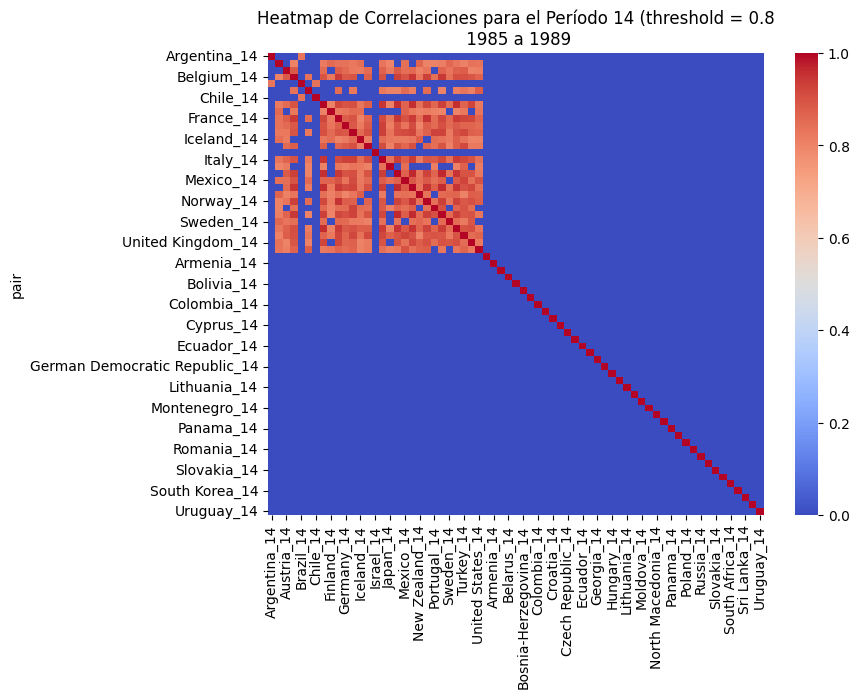

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para visualizar el heatmap de la matriz filtrada
def plot_heatmap(filtered_correlation_matrix, threshold):
    # Aplicar el threshold
    filtered_corr = filtered_correlation_matrix[filtered_correlation_matrix >= threshold].fillna(0)
    
    # Plotear el heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_corr, cmap='coolwarm', annot=False, cbar=True)
    plt.title(f"Heatmap de Correlaciones para el Período {period} (threshold = {threshold}\n {desde} a {hasta}")
    plt.show()

# Usar la función para visualizar el heatmap con un threshold definido
plot_heatmap(filtered_correlation_matrix, threshold)


In [178]:
filtered_correlation_matrix

,Argentina_14,Australia_14,Austria_14,Belgium_14,Brazil_14,Canada_14,Chile_14,Denmark_14,Finland_14,France_14,...,Romania_14,Russia_14,Serbia_14,Slovakia_14,Slovenia_14,South Africa_14,South Korea_14,Sri Lanka_14,Ukraine_14,Uruguay_14
pair,,,,,,,,,,,,,,,,,,,,,
Argentina_14,1.000000,0.600136,0.652232,0.660139,0.830947,0.598663,0.786252,0.633214,0.612693,0.621653,...,0,0,0,0,0,0,0,0,0,0
Australia_14,0.600136,1.000000,0.796855,0.804002,0.588502,0.768496,0.678361,0.818109,0.856469,0.836468,...,0,0,0,0,0,0,0,0,0,0
Austria_14,0.652232,0.796855,1.000000,0.885945,0.610934,0.755101,0.674795,0.853290,0.786364,0.879263,...,0,0,0,0,0,0,0,0,0,0
Belgium_14,0.660139,0.804002,0.885945,1.000000,0.616432,0.838152,0.704545,0.896977,0.826349,0.941140,...,0,0,0,0,0,0,0,0,0,0
Brazil_14,0.830947,0.588502,0.610934,0.616432,1.000000,0.565370,0.838642,0.601077,0.625609,0.586382,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South Africa_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
South Korea_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
Sri Lanka_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0


#### CREAMOS LA RED DE SIMILARIDAD

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_8846/3135907941.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'), label="Correlación")


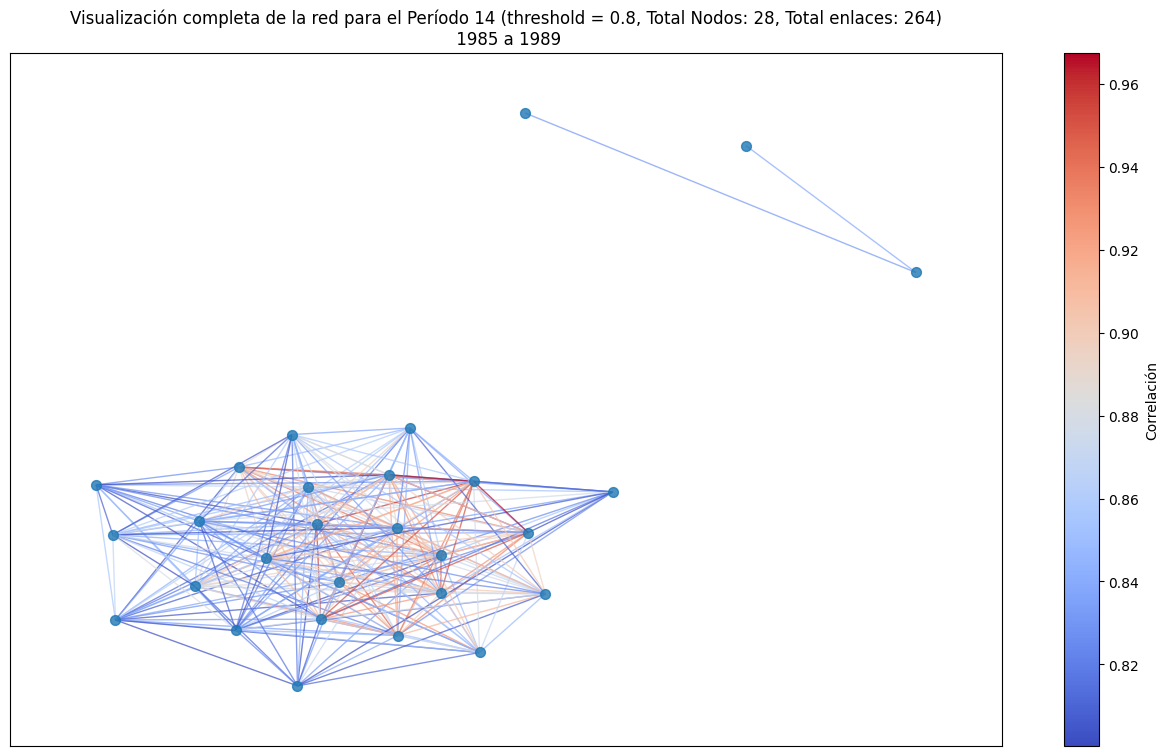

In [179]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Create a graph from the filtered correlation matrix
def create_graph(filtered_correlation_matrix, threshold):
    graph = nx.Graph()
    for pair1 in filtered_correlation_matrix.index:
        for pair2 in filtered_correlation_matrix.columns:
            if pair1 != pair2 and filtered_correlation_matrix.loc[pair1, pair2] >= threshold:
                # Add edge with correlation as weight
                graph.add_edge(pair1, pair2, weight=filtered_correlation_matrix.loc[pair1, pair2])
    return graph

# Create the graph
graph = create_graph(filtered_correlation_matrix, threshold)

# Visualization of the network with color-coded edges based on correlation and adjustable node spacing
def visualize_full_graph_with_colors(graph, period, threshold, k_value):
    plt.figure(figsize=(16, 9))
    # Increase `k` to spread the nodes further apart
    pos = nx.spring_layout(graph, seed=42, k=k_value)
    
    # Extract weights for color mapping
    edges = graph.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]
    
    # Normalize weights for color mapping
    norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [cm.coolwarm(norm(weight)) for weight in weights]  # Use the color map "coolwarm"

    # Draw nodes and edges
    nx.draw_networkx_nodes(graph, pos, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, alpha=0.7)

    plt.title(f"Visualización completa de la red para el Período {period} (threshold = {threshold}, Total Nodos: {len(graph.nodes)}, Total enlaces: {len(graph.edges)})\n {desde} a {hasta}")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'), label="Correlación")
    plt.show()

# Example usage with a higher k value to separate nodes further
visualize_full_graph_with_colors(graph, period, threshold, k_value=1.2)



In [180]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

#### Distribución de grado de la red

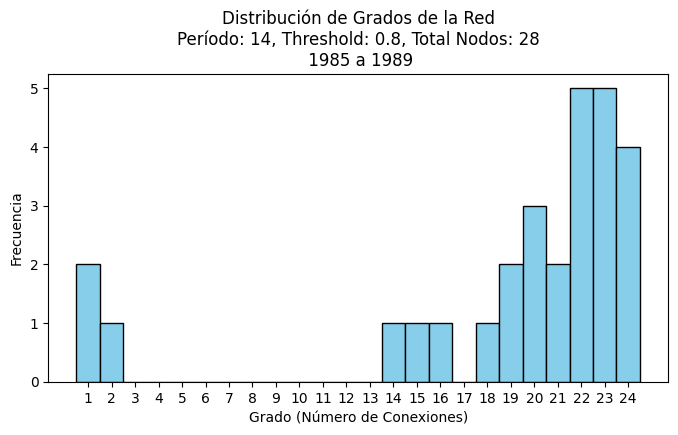

In [181]:
import matplotlib.pyplot as plt

# Función para graficar la distribución de grados
def plot_degree_distribution(graph):
    # Obtener los grados de cada nodo en el grafo
    degrees = [degree for _, degree in graph.degree()]
    
    # Crear el histograma de la distribución de grados
    plt.figure(figsize=(8, 4))
    plt.hist(degrees, bins=range(1, max(degrees) + 2), color='skyblue', edgecolor='black', align='left')
    plt.title(f"Distribución de Grados de la Red\nPeríodo: {period}, Threshold: {threshold}, Total Nodos: {len(graph.nodes())}\n {desde} a {hasta}")
    plt.xlabel("Grado (Número de Conexiones)")
    plt.ylabel("Frecuencia")
    plt.xticks(range(1, max(degrees) + 1))
    plt.show()

# Llamar a la función para graficar la distribución de grados
graph_centralidades = graph.copy()
plot_degree_distribution(graph_centralidades)


In [182]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

#### Centralidad de la red

Aquí tienes las fórmulas en formato Markdown compatible para que se rendericen correctamente:

---

## Medidas de Centralización para Explicar la Centralidad de la Red

Existen varias medidas para cuantificar la **centralidad de una red** en su conjunto, reflejando qué tan centralizada está la red y si ciertos nodos son particularmente "importantes" o "influyentes". A continuación se presentan algunas de las medidas más comunes:

### 1. Degree Centralization (Centralización de grado)
   - **Definición**: Mide el grado en que los nodos de la red están conectados en torno a un nodo o a un pequeño conjunto de nodos. Se calcula comparando el grado de los nodos más conectados con el de todos los demás.
   - **Fórmula**: 

     $$ \text{Degree Centralization} = \frac{\sum_{i} (\text{max degree} - \text{degree}(i))}{(n-1)(n-2)} $$

     donde \( n \) es el número de nodos en la red.
   - **Interpretación**: Un valor alto de centralización de grado indica que la red tiene uno o unos pocos nodos muy conectados (similar a un "hub" en una red de aeropuertos). Un valor bajo sugiere que las conexiones están más distribuidas y no hay nodos particularmente centrales en términos de conexiones.

### 2. Betweenness Centralization (Centralización de intermediación)
   - **Definición**: Mide la centralización de la red en función de la intermediación (**betweenness**) de los nodos, es decir, qué tanto dependen los caminos entre otros nodos de los mismos nodos intermedios.
   - **Fórmula**:

     $$ \text{Betweenness Centralization} = \frac{\sum_{i} (\text{max betweenness} - \text{betweenness}(i))}{(n-1)(n-2)/2} $$

   - **Interpretación**: Una red con alta centralización de intermediación está dominada por unos pocos nodos que actúan como "puentes" o "intermediarios" entre otras partes de la red. Un valor bajo indica que no hay nodos particularmente importantes en términos de intermediación, lo cual podría indicar que la red es más distribuida.

### 3. Closeness Centralization (Centralización de cercanía)
   - **Definición**: Mide qué tan centralizada está la red en términos de cercanía (**closeness**), es decir, qué tan "cercanos" están los nodos entre sí en promedio.
   - **Fórmula**:

     $$ \text{Closeness Centralization} = \frac{\sum_{i} (\text{max closeness} - \text{closeness}(i))}{(n-1)(n-2)} $$

   - **Interpretación**: Una alta centralización de cercanía sugiere que hay uno o unos pocos nodos desde los cuales es fácil llegar a cualquier otro nodo en la red. Un valor bajo indica una red en la que todos los nodos están a distancias similares entre sí y, por lo tanto, no hay nodos significativamente más "cercanos" en términos de la red completa.

### Ejemplo de Cálculo de la Centralización de Grado

### Conclusión
Estas métricas proporcionan una visión cuantitativa de la centralidad de toda la red, lo que permite comparar diferentes redes en términos de su estructura y distribución de influencias. Cada una de estas métricas ofrece una perspectiva diferente sobre la estructura centralizada o distribuida de la red en su conjunto.

---

In [183]:
import networkx as nx

# Crear el grafo
grafo_centralidades = graph.copy()
grafo_centralidades = nx.erdos_renyi_graph(100, 0.05)  # Ejemplo de una red aleatoria

# Calcular Degree Centralization
degree_centrality = nx.degree_centrality(grafo_centralidades)
max_degree_centrality = max(degree_centrality.values())
degree_centralization = sum(max_degree_centrality - v for v in degree_centrality.values()) / ((len(graph) - 1) * (len(graph) - 2))
print(f"Centralización de Grado: {degree_centralization:.4f}")

# Calcular Betweenness Centralization
betweenness_centrality = nx.betweenness_centrality(grafo_centralidades, normalized=True)
max_betweenness_centrality = max(betweenness_centrality.values())
betweenness_centralization = sum(max_betweenness_centrality - v for v in betweenness_centrality.values()) / ((len(graph) - 1) * (len(graph) - 2) / 2)
print(f"Centralización de Intermediación: {betweenness_centralization:.4f}")

# Calcular Closeness Centralization
closeness_centrality = nx.closeness_centrality(grafo_centralidades)
max_closeness_centrality = max(closeness_centrality.values())
closeness_centralization = sum(max_closeness_centrality - v for v in closeness_centrality.values()) / ((len(graph) - 1) * (len(graph) - 2))
print(f"Centralización de Cercanía: {closeness_centralization:.4f}")


Centralización de Grado: 0.0101
Centralización de Intermediación: 0.0222
Centralización de Cercanía: 0.0109


#### DETECCIÓN DE COMUNIDADES

In [184]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

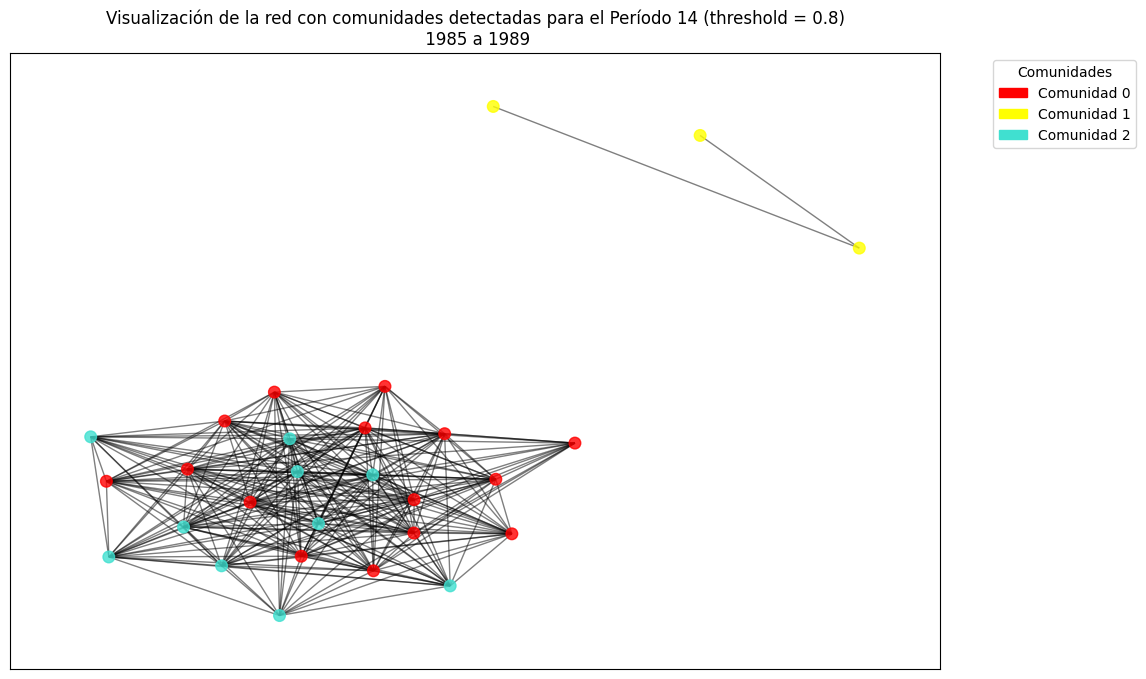

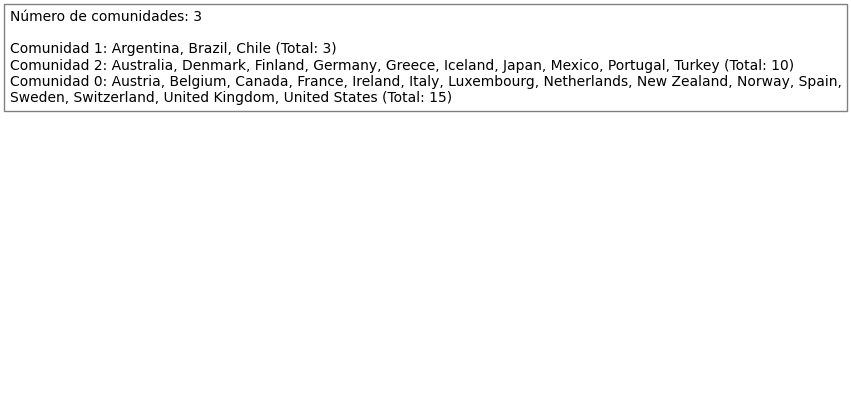

In [185]:
from community import community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

# Crear una copia del grafo con etiquetas numéricas para usar en best_partition
def assign_partition_to_original_graph(graph):
    # Crear una copia del grafo con etiquetas numéricas
    graph_with_integers = nx.convert_node_labels_to_integers(graph, label_attribute="original_name")
    
    # Obtener la partición usando el grafo con nodos numerados
    partition = community_louvain.best_partition(graph_with_integers)
    
    # Mapear la partición a los nombres originales de los nodos
    partition_original = {data["original_name"]: community for node, community in partition.items() for data in [graph_with_integers.nodes[node]]}
    
    return partition_original

# Asignar la partición a los nombres originales del grafo
partition = assign_partition_to_original_graph(graph)

# Función para visualizar el grafo de comunidades con guía de colores
def visualize_communities_graph(graph, partition, period, threshold):
    # Lista de colores llamativos
    color_palette = ['red', 'yellow', 'turquoise', 'green', 'orange', 'purple', 'blue', 'pink']
    
    # Asignar colores a las comunidades
    unique_communities = list(set(partition.values()))
    color_map = [color_palette[partition[node] % len(color_palette)] for node in graph.nodes]

    # Dibujar el grafo
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, seed=42, k=1.2)
    ax = plt.gca()
    nx.draw_networkx_nodes(graph, pos, node_color=color_map, node_size=70, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(graph, pos, alpha=0.5, ax=ax)
    plt.title(f"Visualización de la red con comunidades detectadas para el Período {period} (threshold = {threshold})\n {desde} a {hasta}")

    # Crear leyenda de colores para cada comunidad
    legend_patches = [mpatches.Patch(color=color_palette[i % len(color_palette)], label=f"Comunidad {community}")
                      for i, community in enumerate(unique_communities)]
    plt.legend(handles=legend_patches, title="Comunidades", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Función para mostrar el cuadro de texto con la lista de comunidades y países
def display_community_details(partition):
    communities_dict = {}
    for node, community in partition.items():
        country = node.split('_')[0]
        if community not in communities_dict:
            communities_dict[community] = set()
        communities_dict[community].add(country)
    
    # Crear el texto de la lista de comunidades y sus países
    community_text = [f"Comunidad {community}: {', '.join(sorted(countries))} (Total: {len(countries)})"
                      for community, countries in communities_dict.items()]
    community_info = "\n".join(community_text)

    # Mostrar el cuadro de texto como un gráfico separado
    plt.figure(figsize=(10, 5))
    plt.text(0, 1, f"Número de comunidades: {len(communities_dict)}\n\n{community_info}", 
             fontsize=10, va='top', ha='left', wrap=True, bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.show()

# Visualizar el grafo de comunidades con la guía de colores
visualize_communities_graph(graph, partition, period, threshold)

# Mostrar el cuadro de texto con los países en cada comunidad
display_community_details(partition)


In [186]:
graph.nodes()

NodeView(('Argentina_14', 'Brazil_14', 'Australia_14', 'Belgium_14', 'Denmark_14', 'Finland_14', 'France_14', 'Germany_14', 'Greece_14', 'Iceland_14', 'Italy_14', 'Japan_14', 'Mexico_14', 'New Zealand_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Sweden_14', 'Switzerland_14', 'Turkey_14', 'United Kingdom_14', 'United States_14', 'Austria_14', 'Ireland_14', 'Luxembourg_14', 'Netherlands_14', 'Canada_14', 'Chile_14'))

#### Veamos qué nodos hay en cada comunidad

#### CALCULEMOS LAS MÉTRICAS DE CENTRALIDAD

In [187]:
# Calcular diferentes métricas de centralidad
def calculate_centrality(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    # Convertir a dataframe para visualización
    centrality_df = pd.DataFrame({
        'Degree Centrality': degree_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Closeness Centrality': closeness_centrality
    })

    return centrality_df

# Calcular las métricas de centralidad
centrality_df = calculate_centrality(graph)

# Mostrar los 5 nodos principales para cada métrica de centralidad
def display_top_centrality(centrality_df):
    print(f"centrality_df.head()")

# Mostrar los top 5 nodos por centralidad
display_top_centrality(centrality_df)
centrality_df.head()

centrality_df.head()


,Degree Centrality,Betweenness Centrality,Closeness Centrality
Argentina_14,0.037037,0.000000,0.049383
Brazil_14,0.074074,0.002849,0.074074
Australia_14,0.703704,0.003215,0.735632
Belgium_14,0.814815,0.005005,0.820513
Denmark_14,0.851852,0.005205,0.853333


#### Analicemos las métricas de centralidad en cada nodo

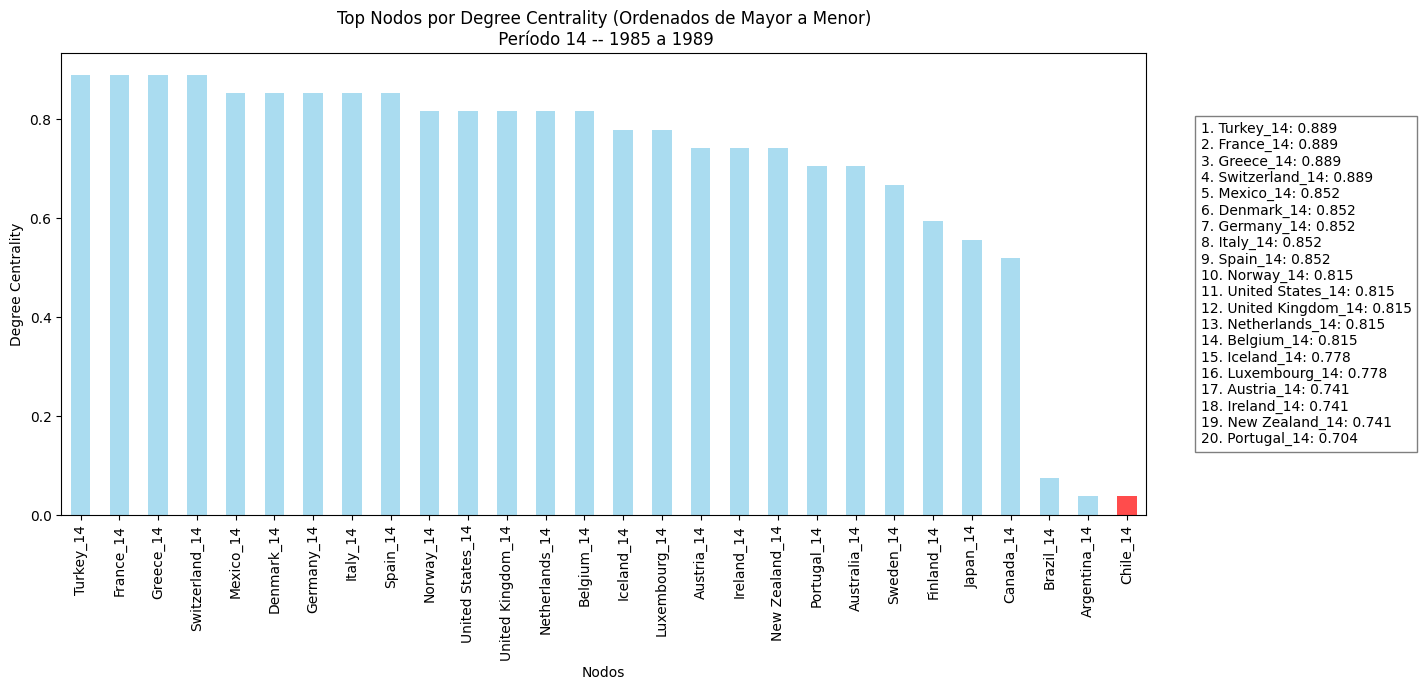

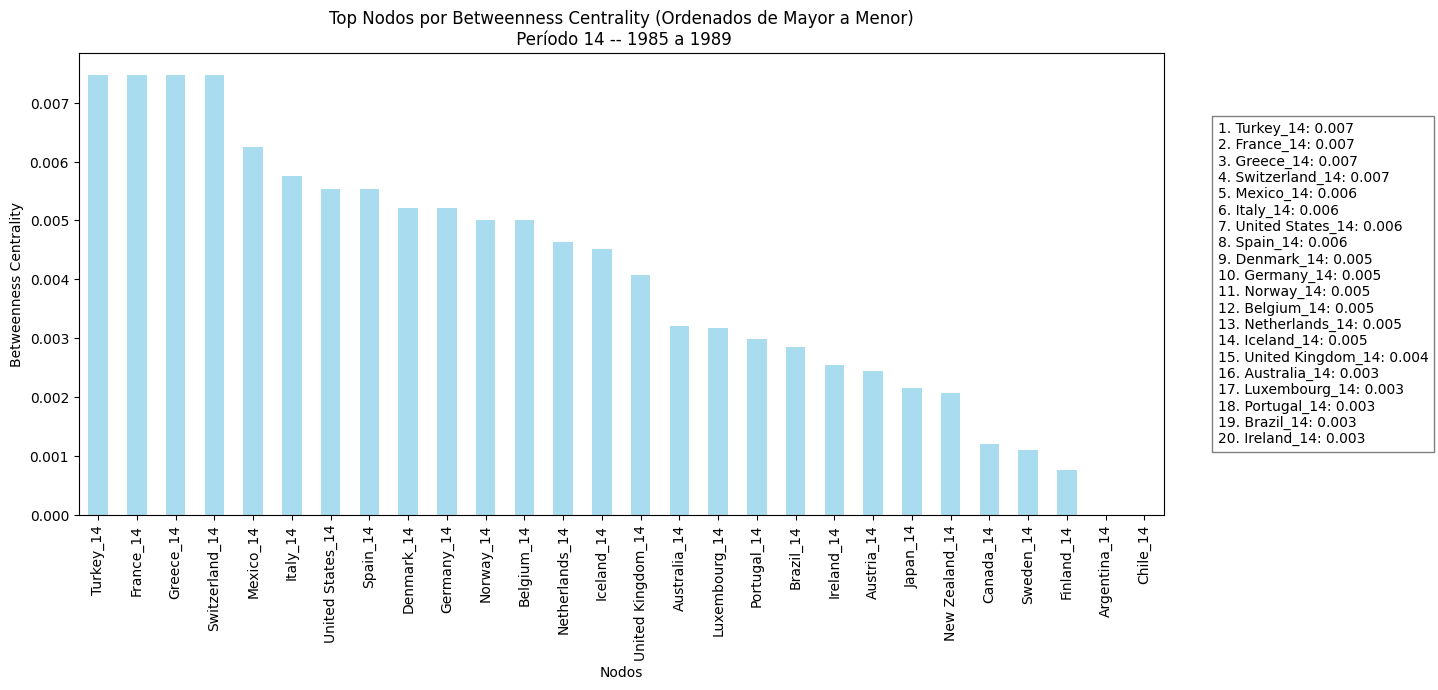

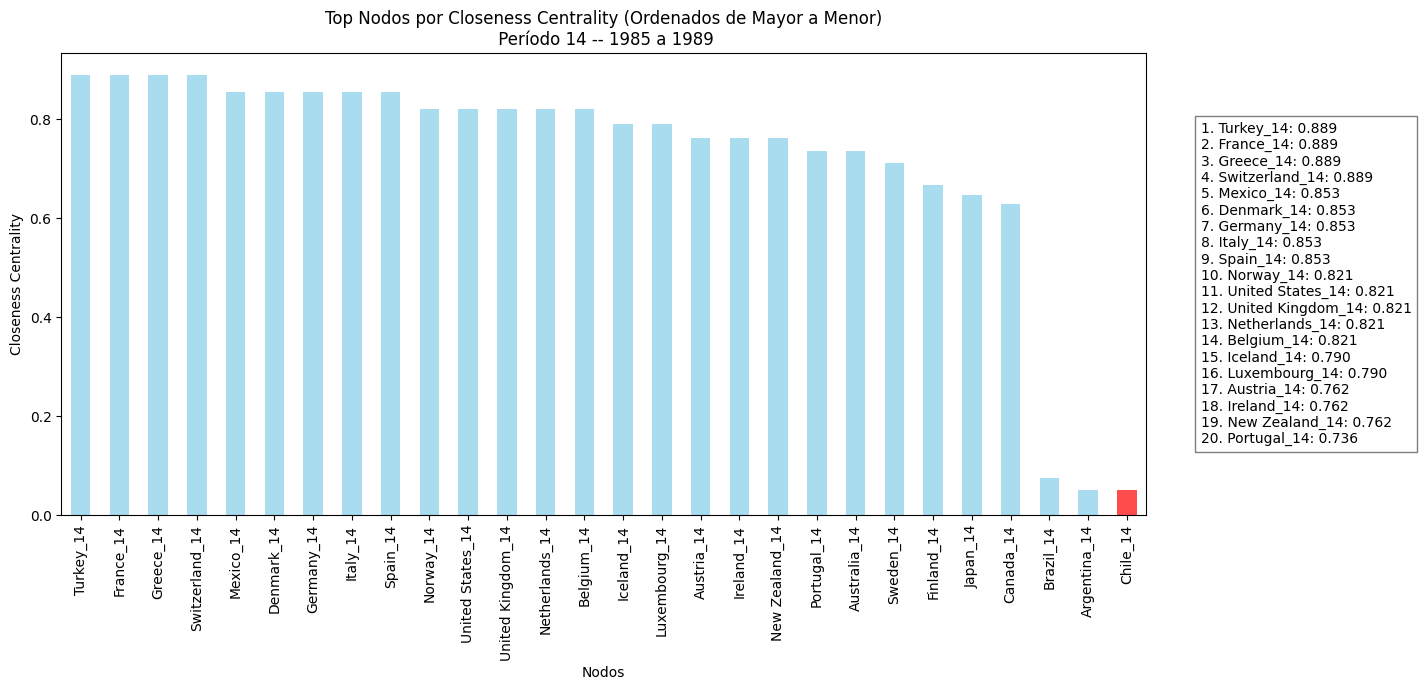

In [188]:
import matplotlib.pyplot as plt

def plot_centrality_bars_with_top_list(centrality_df, metric_name, highlight_country='Chile', top_n=20):
    # Ordenar los valores de la métrica de mayor a menor
    sorted_centrality = centrality_df[metric_name].sort_values(ascending=False)
    
    # Asignar colores: rojo para los nodos que contienen el nombre del país, azul para el resto
    colors = ['red' if highlight_country in index else 'skyblue' for index in sorted_centrality.index]
    
    # Crear un gráfico de barras para la métrica especificada
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    sorted_centrality.plot(kind='bar', color=colors, alpha=0.7, ax=ax)
    plt.title(f"Top Nodos por {metric_name} (Ordenados de Mayor a Menor)\n Período {period} -- {desde} a {hasta}")
    plt.xlabel("Nodos")
    plt.ylabel(metric_name)
    plt.xticks(rotation=90)  # Rotar etiquetas de los nodos para mejor visualización
    
    # Obtener los top 20 nodos
    top_n_df = sorted_centrality.head(top_n)
    top_list = top_n_df.index.tolist()
    values = top_n_df.tolist()
    
    # Crear la lista de texto con los top nodos
    text_list = [f"{i+1}. {node}: {value:.3f}" for i, (node, value) in enumerate(zip(top_list, values))]
    list_text = "\n".join(text_list)
    
    # Agregar la lista de top nodos a la derecha del gráfico
    ax.text(1.05, 0.5, list_text, transform=ax.transAxes, fontsize=10, va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

# Graficar cada métrica de centralidad y mostrar la lista de top 20 nodos a la derecha
plot_centrality_bars_with_top_list(centrality_df, 'Degree Centrality', highlight_country='Chile', top_n=20)
plot_centrality_bars_with_top_list(centrality_df, 'Betweenness Centrality', highlight_country='Chile', top_n=20)
plot_centrality_bars_with_top_list(centrality_df, 'Closeness Centrality', highlight_country='Chile', top_n=20)


#### COMENTARIOS A LA RED DE SIMILARIDAD para el período 15 (1990-1994)

##### RED COMPLETA (Threshold = 0.0), 67 nodos, 2.211 enlaces (el máximo posible para esta cantidad de nodos siendo una red no dirigida)
* La Centralidad de Grado: 0,0013 es baja. Esto muestra que las conexiones están distribuidas y que no hay nodos que hagan de 'nodos centrales'. Todos se relacionan con todos. Desde la perspectiva de nuestro problema, no hay países cuyo programa de gobierno se correlacione de manera significativa con muchos otros países. No hay países que hagan de 'hubs'.
* La Centralización de Intermediación: 0.0032 es baja. Reafirma lo anterior. No hay países que cumplan un rol importante en términos de 'intermediación'
* Centralización de Cercanía: 0.0018 es baja. Esto indica que todos los países están a una distancia similar entre si, y que no hay nodos más "cercanos".
* Comunidades: 16
* Países en la comunidad donde está Chile: 33

##### RED CON Threshold = 0.8, 46 Nodos, 342 enlaces
* La Centralidad de Grado: 0,0027 es baja. Esto muestra que las conexiones están distribuidas y que no hay nodos que hagan de 'nodos centrales'. Todos se relacionan con todos. Desde la perspectiva de nuestro problema, no hay países cuyo programa de gobierno se correlacione de manera significativa con muchos otros países. No hay países que hagan de 'hubs'.
* La Centralización de Intermediación: 0.0057 es baja. Reafirma lo anterior. No hay países que cumplan un rol importante en términos de 'intermediación'
* Centralización de Cercanía: 0.0041 es baja. Esto indica que todos los países están a una distancia similar entre si, y que no hay países más "cercanos".
* Comunidades: 5
* Países en la comunidad donde está Chile: 4 (Brazil, Costa Rica, Panamá)




<h2>Impacto del <code>threshold</code> en las métricas de centralidad</h2>

<p>En realidad, <strong>sí deberían variar las métricas de centralidad</strong> al cambiar el <code>threshold</code>. Aquí está la explicación de por qué:</p>

<h3>Efecto del <code>threshold</code></h3>
<ul>
    <li>El <code>threshold</code> determina qué conexiones (o enlaces) se incluyen en el grafo. Si aumentas o disminuyes el <code>threshold</code>, estarás modificando la estructura del grafo al agregar o eliminar enlaces entre los nodos en función de la correlación.</li>
    <li>Esto significa que al variar el <code>threshold</code>, la cantidad de conexiones entre nodos cambiará, lo cual influye directamente en cómo se calculan las métricas de centralidad.</li>
</ul>

<h3>Cambios en Degree Centrality</h3>
<ul>
    <li><strong>Degree Centrality</strong> depende del número de conexiones directas de un nodo. Si aumentas el <code>threshold</code>, es probable que se eliminen algunas conexiones más débiles, reduciendo el número de conexiones directas de ciertos nodos. Por lo tanto, el <strong>Degree Centrality</strong> de algunos nodos disminuirá al aumentar el <code>threshold</code> y podría aumentar al reducirlo.</li>
</ul>

<h3>Cambios en Betweenness Centrality</h3>
<ul>
    <li><strong>Betweenness Centrality</strong> mide cuántos caminos cortos pasan a través de un nodo. Si los enlaces se eliminan debido a un aumento en el <code>threshold</code>, los caminos más cortos entre nodos también se verán afectados. Algunos nodos que antes conectaban dos partes de la red podrían dejar de hacerlo, disminuyendo su <strong>Betweenness Centrality</strong>.</li>
</ul>

<h3>Cambios en Closeness Centrality</h3>
<ul>
    <li><strong>Closeness Centrality</strong> se basa en la distancia promedio entre un nodo y todos los demás. Si se eliminan enlaces al aumentar el <code>threshold</code>, la distancia entre nodos podría incrementarse. Esto afectará las distancias mínimas y, por lo tanto, la <strong>Closeness Centrality</strong> cambiará al variar el <code>threshold</code>.</li>
</ul>

<h3>Resumen</h3>
<p>Cuando cambias el <code>threshold</code>, la estructura de la red se modifica (al agregar o eliminar enlaces). Dado que todas las métricas de centralidad dependen de la estructura de la red, es <strong>esperable que las métricas de centralidad cambien</strong> en función del <code>threshold</code>. Por eso, si el <code>threshold</code> varía, las métricas que calculaste también podrían cambiar.</p>


#### 30 Oct 2024
#### Temas por revisare en este Notebook:

*       * Hacer la red de correlaciones de nodos todos los países con todos los países (debiera ser una red cuadrada, con 1 en la diagonal)
*       * Fijar un threshold
*       * Fijar una ventana (quedará un nodo por país). Debe quedar un nodo por país.
*       * Analizar 